In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import pickle
from os.path import join

# Assumes there is a .obj directory in the notebook folder
def save_obj(obj, name, root=''):
    with open(join(root, '.obj', name + '.pkl'), 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name, root=''):
    with open(join(root, '.obj/', name + '.pkl'), 'rb') as f:
        return pickle.load(f)

We will use the CIFAR10 dataset. It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

In [4]:
import torch
import torchvision

import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [20]:
len(trainloader)

12500

Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

In [6]:
def _num_flat_features(x):
    size = x.size()[1:]  # all dimensions except the batch dimension
    num_features = 1
    for s in size:
        num_features *= s
    return num_features


class Net_C(nn.Module):
    def __init__(self, M, p, N):
        '''
        M is the number of output channels, p is the convolution kernel size, 
        N is the max pooling kernel (ideally, it is a divisor of 33-p)
        '''
        super(Net_C, self).__init__()
        # 3 input image channel, M output channels, pxpx3 square convolution; bias=True is default
        self.conv1 = nn.Conv2d(3, M, p)
        self.pool1 = nn.MaxPool2d(N)
        self.fc1 = nn.Linear(M*((33-p)//N)**2, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = x.view(-1, self.num_flat_features(x)) # 32 * 32 * 3
        x = self.fc1(x)
        return x
    
    def num_flat_features(self, x):
        return _num_flat_features(x)
    

class Net_B(nn.Module):
    def __init__(self, M):
        super(Net_B, self).__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, M)
        self.fc2 = nn.Linear(M, 10)

    def forward(self, x):
        x = x.view(-1, self.num_flat_features(x)) # 32 * 32 * 3
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def num_flat_features(self, x):
        return _num_flat_features(x)
    

class Net_A(nn.Module):
    def __init__(self):
        super(Net_A, self).__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 10)

    def forward(self, x):
        x = x.view(-1, self.num_flat_features(x)) # 32 * 32 * 3
        x = self.fc1(x) 
        return x
    
    def num_flat_features(self, x):
        return _num_flat_features(x)

In [48]:
def train_net(net, iter_trainloader, criterion, optimizer, epochs, iter_testloader=None):
    '''
    Trains net and returns epoch-wise test loss
    '''
    epochs_train_loss = []
    epochs_test_loss = []
    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        size = 0
        for i, data in enumerate(iter_trainloader):
            # get the inputs
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 4000 == 3999:    # print every 4000 mini-batches
                epochs_train_loss.append([epoch, i, running_loss / 4000])
                running_loss = 0.0
            size+=1
        if iter_testloader:
            test_loss,_ = test_net(netA, iter_testloader, criterion)
            epochs_test_loss.append([epoch, size, test_loss])
    return epochs_train_loss, epochs_test_loss

In [49]:
def test_net(net, iter_testloader, criterion):
    with torch.no_grad():
        correct = 0
        total = 0
        test_loss = 0.0
        size = 0
        for data in iter_testloader:
            images, labels = data
            outputs = net(images)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            # Sum statistics
            test_loss += loss.item()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            size += 1
    return test_loss / size, 100 * correct / total

In [50]:
def percent_accuracy(net, iter_testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

In [24]:
# Shared criterion for loss
criterion_all = nn.CrossEntropyLoss()

Making sure everything works...
-----------

In [12]:
# # Create new NN's, print
# # netA = Net_A()
# # netB = Net_B(100)
# # netC = Net_C(100, 5, 2)
# print(netA)
# print(netB)
# print(netC)

In [16]:
# # This code made sure the NN's functioned correctly
test_input = torch.randn(4, 3, 32, 32)
# for inet in [netB]:
#     out = inet(test_input)
#     print(out)

working with Network A
---------------

In [96]:
netA = Net_A()
resA=[]

In [104]:
# Declare some optimizer for Net A
optimizerA = optim.SGD(netA.parameters(), lr=0.0001, momentum=0.01)

In [105]:
%%time
resA_train, resA_test = train_net(netA, trainloader, criterion_all, optimizerA, 10, testloader)

CPU times: user 16min 52s, sys: 51.9 s, total: 17min 44s
Wall time: 9min 3s


In [106]:
print('train:\t', ', '.join(['%.3f' % i[2] for i in resA_train]))
print('test:\t', ', '.join(['%.3f' % i[2] for i in resA_test]))
loss, percent = test_net(netA, testloader, criterion_all)
print('test:\t', '%.3f' % loss )
print('%d%% accuracy on 10000 test images.' % percent)

train:	 1.709, 1.652, 1.614, 1.605, 1.589, 1.595, 1.585, 1.563, 1.584, 1.567, 1.561, 1.572, 1.562, 1.581, 1.545, 1.556, 1.573, 1.546, 1.554, 1.544, 1.570, 1.548, 1.547, 1.561, 1.547, 1.544, 1.561, 1.533, 1.557, 1.556
test:	 1.900, 1.874, 1.865, 1.856, 1.850, 1.847, 1.843, 1.841, 1.839, 1.837
test:	 1.837
38% accuracy on 10000 test images.


In [118]:
_, resA_train_0, resA_test_0 = load_obj('netA_20epoch_01_01')

In [119]:
print('train:\t', ', '.join(['%.3f' % i[2] for i in resA_train_0]))
print('test:\t', ', '.join(['%.3f' % i[2] for i in resA_test_0]))

train:	 2.038, 2.047, 2.053, 2.000, 2.073, 2.060, 1.996, 2.045, 2.080, 2.006, 2.037, 2.070, 2.001, 2.049, 2.059, 2.010, 2.044, 2.041, 2.000, 2.052, 2.047, 2.012, 2.029, 2.037, 1.998, 2.043, 2.046, 2.006, 2.041, 2.041
test:	 2.304, 2.279, 2.213, 2.132, 2.235, 2.123, 2.230, 2.245, 2.264, 2.228


In [120]:
resA_train_0 = np.array(resA_train_0)
resA_test_0 = np.array(resA_test_0)
resA_train = np.array(resA_train)
resA_test = np.array(resA_test)

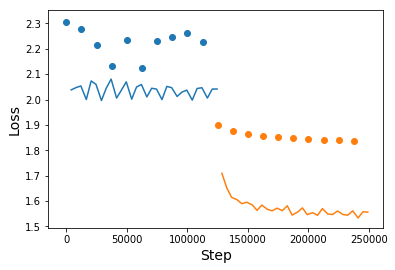

In [137]:
plt.plot(resA_train_0[:,0]*12500 + resA_train_0[:,1], resA_train_0[:,2])
prev = np.max(resA_train_0[:,0]*12500 + resA_train_0[:,1])
plt.plot(prev + resA_train[:,0]*12500 + resA_train[:,1], resA_train[:,2])

plt.scatter(resA_test_0[:,0]*12500, resA_test_0[:,2])
prev_test = np.max((resA_test_0[:,0]+1)*12500)
plt.scatter(prev_test + resA_test[:,0]*12500, resA_test[:,2])
plt.xlabel('Step', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.savefig('figs/p5_net_a.pdf')

In [107]:
# save_obj(name='netA_20epoch_0001_01', obj=[netA, resA_train, resA_test])

Comments:

optimizerA = optim.SGD(netA.parameters(), lr=0.01, momentum=0.001)
train:	 2.201, 2.173, 2.162, 2.105, 2.129, 2.154, 2.112, 2.089, 2.101, 2.063, 2.094, 2.108, 2.061, 2.094, 2.080, 2.056, 2.071, 2.094, 2.037, 2.086, 2.079, 2.040, 2.065, 2.071, 2.021, 2.079, 2.063, 2.038, 2.043, 2.061
test:	 2.264, 2.223, 2.224, 2.263, 2.185, 2.196, 2.071, 2.293, 2.144, 2.279
test:	 2.279
33% accuracy on 10000 test images.

optimizerA = optim.SGD(netA.parameters(), lr=0.212, momentum=0.841)
train:	 175.991, 184.557, 185.608, 179.114, 184.203, 181.720, 178.520, 182.050, 186.387, 177.853, 184.370, 181.839, 173.380, 181.109, 182.531, 173.967, 177.103, 180.946, 173.629, 176.575, 180.742, 176.386, 176.638, 176.180, 176.842, 178.391, 181.318, 174.182, 177.223, 178.008
test:	 204.613, 188.560, 183.347, 186.685, 169.764, 200.698, 214.378, 189.993, 182.198, 188.476
test:	 188.476
27% accuracy on 10000 test images.

optimizerA = optim.SGD(netA.parameters(), lr=0.0831, momentum=0.945)
train:	 317.963, 262.889, 249.661, 228.552, 228.060, 223.247, 211.591, 216.781, 212.178, 205.501, 209.789, 208.317, 204.507, 206.900, 202.755, 196.580, 207.313, 204.035, 202.587, 202.032, 199.665, 199.495, 197.132, 206.281, 193.820, 207.734, 205.755, 199.321, 199.586, 201.819
test:	 272.428, 248.242, 233.457, 217.928, 218.635, 235.688, 224.741, 258.207, 239.864, 199.299
test:	 199.299
29% accuracy on 10000 test images.

lr = 0.05, p = .9
train:	 79.920, 76.249, 73.668, 71.825, 70.093, 69.397
test:	 76.059
28% accuracy on 10000 test images.
CPU times: user 3min 1s, sys: 8.29 s, total: 3min 10s
Wall time: 1min 29s

3 miuntes for 2 epochs => 15 minutes for 10 epochs

If 3 hours alloted, number of random guesses allowed: 4*3 = 12

working with Network B
---------------

In [118]:
netB = Net_B(400)
resB=[]

In [119]:
optimizerB = optim.SGD(netB.parameters(), lr=0.01, momentum=0.7)

In [120]:
netB(test_input)

tensor([[ 0.4090, -0.0641,  0.0474, -0.1546,  0.2635,  0.1513,  0.3057, -0.3078,
         -0.2881,  0.1360],
        [-0.1789, -0.2995, -0.0761,  0.1897,  0.1121,  0.3744,  0.0944, -0.1846,
         -0.1328, -0.1426],
        [-0.0523, -0.0421, -0.3660,  0.0535, -0.1048,  0.1844, -0.0085, -0.0769,
         -0.2485, -0.0773],
        [-0.0363, -0.0456,  0.4121, -0.3898, -0.1444,  0.0878,  0.1636, -0.3042,
         -0.1371,  0.0013]], grad_fn=<ThAddmmBackward>)

In [121]:
%%time
resB.extend(train_net(netB, trainloader, criterion_all, optimizerB, 2))
print('train:\t', ', '.join(['%.3f' % i for i in resB]))
loss, percent = test_net(netB, testloader, criterion_all)
print('test:\t', '%.3f' % loss )
print('%d%% accuracy on 10000 test images.' % percent)

train:	 2.036, 2.048
test:	 2.109
38% accuracy on 10000 test images.
CPU times: user 12min 4s, sys: 14.7 s, total: 12min 18s
Wall time: 5min 31s


Comments:

m=100,lr=.01,p=[0.5,.7]
train:	 1.916, 1.851
test:	 1.988
37% accuracy on 10000 test images.
CPU times: user 4min 57s, sys: 11.4 s, total: 5min 8s
Wall time: 2min 23s

Why did B report nan for solutions with lr = 0.05 and p = .9? That's garbage.
Tried .1. Still garbage. So can't learn too quickly.
I tried  with lr = .01 and p=0.5 and it converged nicely.
I tried it with lr=0.001, momentum=0.5 and I got answers but it never moved.

Similar time for A and B: B was 2min 21s for lr = .01 and p=.5 and M = 100
When M=400, this time went to: 5 minutes

working with Network C
-----------------------

In [129]:
netC = Net_C(100, 6, 4)
resC=[]

In [130]:
netC(test_input);

In [131]:
optimizerC = optim.SGD(netC.parameters(), lr=0.01, momentum=0.5)

In [138]:
%%time
resC.extend(train_net(netC, trainloader, criterion_all, optimizerC, 2))
print('train:\t', ', '.join(['%.3f' % i for i in resC]))
loss, percent = test_net(netC, testloader, criterion_all)
print('test:\t', '%.3f' % loss )
print('%d%% accuracy on 10000 test images.' % percent)

train:	 1.392, 1.223, 1.173, 1.140, 1.109, 1.086, 1.062, 1.047
test:	 1.336
60% accuracy on 10000 test images.
CPU times: user 10min 45s, sys: 12.7 s, total: 10min 58s
Wall time: 4min 42s


In [139]:
save_obj(name='netC_lr01_m5_100_6_4', obj=[netC, resC])

Comments:

Training lr=0.01, p=.5 on Net_C(100, 5, 2) gives time of 6 minutes. Errors were at ~1.2 at 2 epochs. 

netC = Net_C(100, 6, 4)
lr=0.01, momentum=0.5
train:	 1.392, 1.223
test:	 1.404
55% accuracy on 10000 test images.
CPU times: user 11min 35s, sys: 13.5 s, total: 11min 48s
Wall time: 5min 5s

Fun novelty functions 
------------

In [83]:
def categorical_percent_error(net, iter_testloader):
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1


    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

In [128]:
categorical_percent_error(netC, testloader)

Accuracy of plane : 64 %
Accuracy of   car : 71 %
Accuracy of  bird : 43 %
Accuracy of   cat : 33 %
Accuracy of  deer : 50 %
Accuracy of   dog : 44 %
Accuracy of  frog : 75 %
Accuracy of horse : 63 %
Accuracy of  ship : 75 %
Accuracy of truck : 55 %


In [84]:
categorical_percent_error(netA, testloader)

Accuracy of plane : 32 %
Accuracy of   car : 50 %
Accuracy of  bird : 17 %
Accuracy of   cat : 25 %
Accuracy of  deer : 17 %
Accuracy of   dog : 29 %
Accuracy of  frog : 32 %
Accuracy of horse : 22 %
Accuracy of  ship : 33 %
Accuracy of truck : 10 %
